# Dense network
Finally, try with neural networks

 - 1-layer dense network i.e. no hidden layer, just the input and output ones
 - 2-layer dense network i.e. one hidden layer

1 layer dense network without hidden layers

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers, losses, metrics
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras

from tensorflow.keras import activations
from tensorflow.keras import initializers

import numpy as np
import pandas as pd
import os
import PIL.Image as Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X_tr = np.load('features_tr.npy')
y_tr = np.load('labels_tr.npy')

X_valid = np.load('features_valid.npy')
y_valid = np.load('labels_valid.npy')

X_test = np.load('features_test.npy')
y_test = np.load('labels_test.npy')

In [3]:
X_cv = np.concatenate((X_tr, X_valid), axis = 0)
y_cv = np.concatenate((y_tr, y_valid), axis = 0)

In [4]:
X_tr.shape[1]

2048

I will train my data with image generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# or we do not need to do image augmantation to change the dataset here
train_generator = ImageDataGenerator(rescale = 1/255)
valid_generator = ImageDataGenerator(rescale = 1/255)
test_generator = ImageDataGenerator(rescale = 1/255)

In [6]:
trainset = train_generator.flow_from_directory(
    os.path.join('swissroads','train'), batch_size = 280, target_size = (299,299), shuffle = False, class_mode = 'sparse')

validset = valid_generator.flow_from_directory(
    os.path.join('swissroads', 'valid'), batch_size = 139, target_size = (299, 299), shuffle = False, class_mode = 'sparse')

testset = test_generator.flow_from_directory(
    os.path.join('swissroads', 'test'), batch_size = 50, target_size = (299,299), shuffle = False, class_mode = 'sparse')

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [7]:
len(trainset)

1

### Pipeline ? can we define a pipeline? -->Wrapper 

In [8]:
pca = PCA(n_components = 170)
pca.fit(X_tr, y = None)
X_tr_preprocessed = pca.transform(X_tr)
X_te_preprocessed = pca.transform(X_test)
X_valid_preprocessed = pca.transform(X_valid)

I will mainly work with the objects from its layers keras submodule and assemble them in a Sequential model.

### Model 1L

In [9]:
### How do we choose the size of the hidden layers (number of neurons)? Guidelines?


model1 = Sequential()

# build a dense 1L neural network, add one dense layer

# model.add(Dense(30, activation = 'relu', input_dim = X_tr_preprocessed.shape[1]))
# model.add(Dense(30, activation = 'relu', input_shape = (180, 299, 299, 3)))

# if no generators used (scaler may not be needed)
# scaler = StandardScaler()
# X_tr_preprocessed = scaler.fit_transform(X_tr.reshape([-1, 2048]).astype(float))
# X_te_preprocessed = scaler.transform( X_test.reshape([-1, 2048]).astype(float))
# print('Train:', X_tr_preprocessed.shape) # (60000, 784)
# print('Test:', X_te_preprocessed.shape) # (10000, 784)
# model.add(Dense(30, activation = 'relu', input_dim = X_tr.shape[1]))

#add an output layer
model1.add(Dense(6, activation = 'softmax', input_dim = X_tr_preprocessed.shape[1]))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 1026      
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [10]:
model1.compile(optimizer = optimizers.SGD(lr=0.01), # .. or optimizer='sgd' or 'adam'
              # .. or losses.sparse_categorical_crossentropy
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])  # .. or metrics.sparse_categorical_accuracy

In [11]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [12]:
# fit the model
history1 = model1.fit(
                x=X_tr_preprocessed, 
                y=y_tr,
                #validation_split=0.2, 
                batch_size=32, 
                epochs=50,
                validation_data=(X_valid_preprocessed, y_valid),
                shuffle=True # Shuffle training samples
                )

Train on 280 samples, validate on 139 samples
Epoch 1/50
280/280 [==============================] - 1s 4ms/step - loss: 1.9173 - acc: 0.2929 - val_loss: 1.4645 - val_acc: 0.3813
Epoch 2/50
280/280 [==============================] - 0s 77us/step - loss: 1.4019 - acc: 0.4964 - val_loss: 1.1099 - val_acc: 0.5827
Epoch 3/50
280/280 [==============================] - 0s 79us/step - loss: 1.0937 - acc: 0.6357 - val_loss: 0.9039 - val_acc: 0.7122
Epoch 4/50
280/280 [==============================] - 0s 78us/step - loss: 0.9029 - acc: 0.7107 - val_loss: 0.7754 - val_acc: 0.7194
Epoch 5/50
280/280 [==============================] - 0s 80us/step - loss: 0.7766 - acc: 0.7393 - val_loss: 0.6884 - val_acc: 0.7626
Epoch 6/50
280/280 [==============================] - 0s 83us/step - loss: 0.6850 - acc: 0.7714 - val_loss: 0.6248 - val_acc: 0.7698
Epoch 7/50
280/280 [==============================] - 0s 77us/step - loss: 0.6142 - acc: 0.7786 - val_loss: 0.5761 - val_acc: 0.7842
Epoch 8/50
280/280 [====

In [13]:
history1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

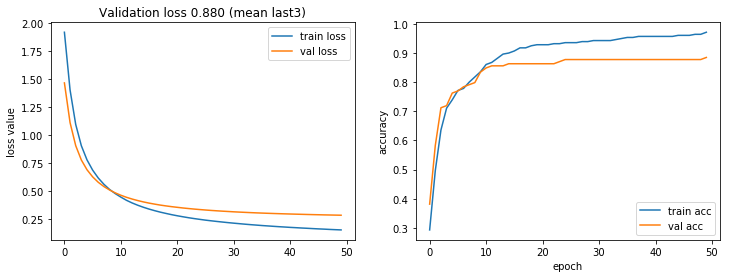

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax1.plot(history1.history['loss'], label = 'train loss')
ax1.plot(history1.history['val_loss'], label = 'val loss')
ax1.set_title('Validation loss {:.3f} (mean last3)'.format(np.mean(history1.history['val_acc'][-3:])))
ax1.set_label('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

ax2.plot(history1.history['acc'], label = 'train acc')
ax2.plot(history1.history['val_acc'], label = 'val acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

In [15]:
(test_loss, test_accuracy) = model1.evaluate(X_te_preprocessed, y_test)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy))

50/50 [==============================] - 0s 87us/step
Test loss: 0.18
Test accuracy: 92.00%


In [16]:
test_accuracy_1L = test_accuracy

In [17]:
results_1L_nn = { 'model': ['1-layer_nn'], 'accuracy' : [test_accuracy_1L] }
results_1L_nn = pd.DataFrame(results_1L_nn)
np.save('results_1L_nn', results_1L_nn)
results_1L_nn

,model,accuracy
0,1-layer_nn,0.92


### Model 2L

In [18]:
model2 = Sequential()

#build a dense 1L neural network, add one dense layer

model2.add(Dense(30, activation = 'relu', input_dim = X_tr_preprocessed.shape[1]))
# model.add(Dense(30, activation = 'relu', input_shape = (180, 299, 299, 3)))

# if no generators used (scaler may not be needed)
# scaler = StandardScaler()
# X_tr_preprocessed = scaler.fit_transform(X_tr.reshape([-1, 2048]).astype(float))
# X_te_preprocessed = scaler.transform( X_test.reshape([-1, 2048]).astype(float))
# print('Train:', X_tr_preprocessed.shape) # (60000, 784)
# print('Test:', X_te_preprocessed.shape) # (10000, 784)
# model.add(Dense(30, activation = 'relu', input_dim = X_tr.shape[1]))

#add an output layer
model2.add(Dense(6, activation = 'softmax'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                5130      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 186       
Total params: 5,316
Trainable params: 5,316
Non-trainable params: 0
_________________________________________________________________


I specify the variance scaling technique for initializing the weights. Define the loss function and training operation.

In [19]:
model2.compile(optimizer = optimizers.SGD(lr=0.01), # .. or optimizer='sgd' or 'adam'
              # .. or losses.sparse_categorical_crossentropy
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])  # .. or metrics.sparse_categorical_accuracy

this step could be avoided, with additional scaling we might loose information

In [20]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [21]:
# fit the model
history = model2.fit(
                x=X_tr_preprocessed, 
                y=y_tr,
                #validation_split=0.2, 
                batch_size=32, 
                epochs=50,
                validation_data=(X_valid_preprocessed, y_valid),
                shuffle=True # Shuffle training samples
                )

Train on 280 samples, validate on 139 samples
Epoch 1/50
280/280 [==============================] - 1s 2ms/step - loss: 2.1992 - acc: 0.1464 - val_loss: 1.8238 - val_acc: 0.1942
Epoch 2/50
280/280 [==============================] - 0s 89us/step - loss: 1.7008 - acc: 0.3679 - val_loss: 1.4274 - val_acc: 0.5324
Epoch 3/50
280/280 [==============================] - 0s 79us/step - loss: 1.3726 - acc: 0.5214 - val_loss: 1.1712 - val_acc: 0.6475
Epoch 4/50
280/280 [==============================] - 0s 75us/step - loss: 1.1501 - acc: 0.6357 - val_loss: 0.9964 - val_acc: 0.7122
Epoch 5/50
280/280 [==============================] - 0s 93us/step - loss: 0.9883 - acc: 0.7143 - val_loss: 0.8681 - val_acc: 0.7554
Epoch 6/50
280/280 [==============================] - 0s 78us/step - loss: 0.8641 - acc: 0.7607 - val_loss: 0.7717 - val_acc: 0.7698
Epoch 7/50
280/280 [==============================] - 0s 75us/step - loss: 0.7682 - acc: 0.8071 - val_loss: 0.6979 - val_acc: 0.7914
Epoch 8/50
280/280 [====

In [22]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

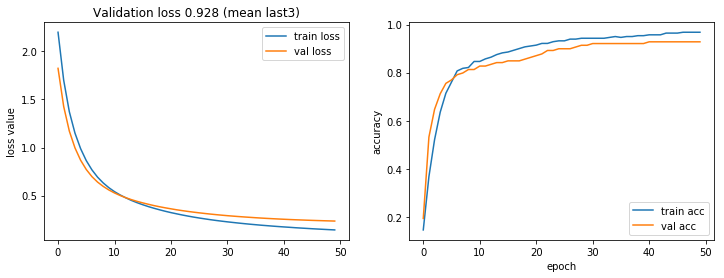

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax1.plot(history.history['loss'], label = 'train loss')
ax1.plot(history.history['val_loss'], label = 'val loss')
ax1.set_title('Validation loss {:.3f} (mean last3)'.format(np.mean(history.history['val_acc'][-3:])))
ax1.set_label('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

ax2.plot(history.history['acc'], label = 'train acc')
ax2.plot(history.history['val_acc'], label = 'val acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

I will now evaluate the test scores.

In [24]:
(test_loss, test_accuracy) = model2.evaluate(X_te_preprocessed, y_test)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy))

50/50 [==============================] - 0s 251us/step
Test loss: 0.20
Test accuracy: 92.00%


In [25]:
test_accuracy_2L = test_accuracy

In [26]:
results_2L_nn = { 'model': ['2-layer_nn'], 'accuracy' : [test_accuracy_2L] }
results_2L_nn = pd.DataFrame(results_2L_nn)
np.save('results_2L_nn', results_1L_nn)
results_2L_nn

,model,accuracy
0,2-layer_nn,0.92


I will visualize the weights

In [27]:
model2.layers

In [28]:
model2.layers[0]

### Model 3L

In [29]:
from tensorflow.keras import activations
from tensorflow.keras import initializers

model3 = Sequential()

#build a dense 1L neural network, add one dense layer

model3.add(Dense(30, activation = 'relu', input_dim = X_tr_preprocessed.shape[1], 
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))
model3.add(Dense(15, activation = 'relu'))

# if no generators used (scaler may not be needed)
# scaler = StandardScaler()
# X_tr_preprocessed = scaler.fit_transform(X_tr.reshape([-1, 2048]).astype(float))
# X_te_preprocessed = scaler.transform( X_test.reshape([-1, 2048]).astype(float))
# print('Train:', X_tr_preprocessed.shape) # (60000, 784)
# print('Test:', X_te_preprocessed.shape) # (10000, 784)
# model.add(Dense(30, activation = 'relu', input_dim = X_tr.shape[1]))

#add an output layer
model3.add(Dense(6, activation = 'softmax'))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                5130      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 96        
Total params: 5,691
Trainable params: 5,691
Non-trainable params: 0
_________________________________________________________________


In [30]:
model3.compile(optimizer = optimizers.SGD(lr=0.01), # .. or optimizer='sgd' or 'adam'
              # .. or losses.sparse_categorical_crossentropy
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])  # .. or metrics.sparse_categorical_accuracy

In [31]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [32]:
# fit the model
history3 = model3.fit(
                x=X_tr_preprocessed, 
                y=y_tr,
                #validation_split=0.2, 
                batch_size=32, 
                epochs=50,
                validation_data=(X_valid_preprocessed, y_valid),
                shuffle=True # Shuffle training samples
                )

Train on 280 samples, validate on 139 samples
Epoch 1/50
280/280 [==============================] - 2s 6ms/step - loss: 1.7103 - acc: 0.2286 - val_loss: 1.5039 - val_acc: 0.2950
Epoch 2/50
280/280 [==============================] - 0s 262us/step - loss: 1.5269 - acc: 0.3429 - val_loss: 1.3534 - val_acc: 0.4173
Epoch 3/50
280/280 [==============================] - 0s 194us/step - loss: 1.3824 - acc: 0.4500 - val_loss: 1.2404 - val_acc: 0.5108
Epoch 4/50
280/280 [==============================] - 0s 153us/step - loss: 1.2735 - acc: 0.4893 - val_loss: 1.1531 - val_acc: 0.5827
Epoch 5/50
280/280 [==============================] - 0s 188us/step - loss: 1.1867 - acc: 0.5643 - val_loss: 1.0830 - val_acc: 0.6475
Epoch 6/50
280/280 [==============================] - 0s 126us/step - loss: 1.1134 - acc: 0.6036 - val_loss: 1.0238 - val_acc: 0.6691
Epoch 7/50
280/280 [==============================] - 0s 159us/step - loss: 1.0516 - acc: 0.6571 - val_loss: 0.9728 - val_acc: 0.6978
Epoch 8/50
280/280

In [33]:
history3.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

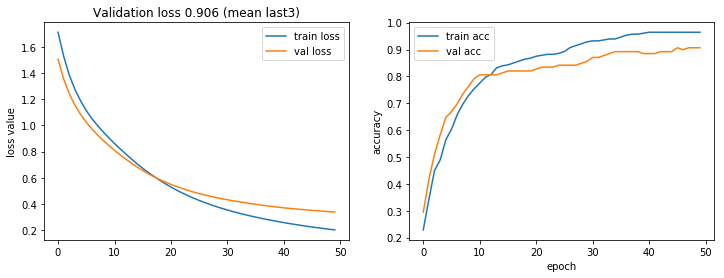

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax1.plot(history3.history['loss'], label = 'train loss')
ax1.plot(history3.history['val_loss'], label = 'val loss')
ax1.set_title('Validation loss {:.3f} (mean last3)'.format(np.mean(history3.history['val_acc'][-3:])))
ax1.set_label('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

ax2.plot(history3.history['acc'], label = 'train acc')
ax2.plot(history3.history['val_acc'], label = 'val acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

In [35]:
(test_loss, test_accuracy) = model3.evaluate(X_te_preprocessed, y_test)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy))

50/50 [==============================] - 0s 396us/step
Test loss: 0.29
Test accuracy: 92.00%


In [36]:
model3.layers

In [37]:
test_accuracy_3L = test_accuracy

In [38]:
results_3L_nn = { 'model': ['3-layer_nn'], 'accuracy' : [test_accuracy_3L] }
results_3L_nn = pd.DataFrame(results_3L_nn)
np.save('results_3L_nn', results_3L_nn)
results_3L_nn

,model,accuracy
0,3-layer_nn,0.92
